# Introduction to `gpvolve` library

## 1. Generating a sample genotype-phenotype map using `gpmap`

Let's start by simulating a random genotype-phenotype map using `gpmap` and computing its genotypes' neighbors (genotypes that can be reached by others through a single mutation, not computed automatically).

In [1]:
from gpmap.simulate import generate_fuji

In [2]:
gpm = generate_fuji(num_sites=5,num_states_per_site=2)
gpm.get_neighbors()

* The data inside the `gpmap` object is stored in two pandas dataframes, `gpm.data` and `gpm.neighbors`. 
* `gpvolve` both uses and builds on top of these dataframes to ensure full compatibility.

In [3]:
# Observe the underlying dataframes
gpm.data.head()

,genotype,include,binary,n_mutations,name,phenotype
0,DKLYY,True,00000,0,wildtype,1.0
1,DKLYA,True,00001,1,Y4A,0.9
2,DKLIY,True,00010,1,Y3I,0.9
3,DKLIA,True,00011,2,Y3I/Y4A,0.8
4,DKIYY,True,00100,1,L2I,0.9


In [4]:
# Neighbors dataframe
gpm.neighbors.head()

,edge,include,source,target,direction
0,"(0, 0)",True,0,0,0
1,"(0, 1)",True,0,1,1
2,"(1, 0)",True,1,0,-1
3,"(0, 2)",True,0,2,1
4,"(2, 0)",True,2,0,-1


#### Important notes:

`gpm.data` and `gpm.neighbors` are pandas dataframes, meaning they can generally be accessed, edited, and sliced in standard pandas fashion. To allow *gpmap* to keep the two dataframes in sync, there are a few limits. Primarily, these are: 1) edit rows and columns using pandas `inplace` operations, 2) do not manually edit the reserved columns mentioned above, and 3) do not manually alter the row indexes for either dataframe. (See the *Rules of the Road* section for more details). 

*See `gpmap` documentation for a more in-depth description.*

## 2. Adding a `fitness` column to `gpmap` data

`gpvolve` references the fitness column for all its calculations, so you must make sure the genotype-phenotype map contains a column labeled `fitness`. It is up to the user to calculate and add this to `gpm.data`.

<span style="color:red"><b>To use `gpvolve`, a "fitness" column must be present on `gpm.data`.</b></span>

### Phenotype to fitness functions

`gpvolve` includes a collection of functions to convert phenotype to fitness. Let's start by importing one of these functions:

In [5]:
from gpvolve.phenotype_to_fitness import linear

/home/luis/Documents/gpvolve/gpvolve/simulate/wright_fisher/wright_fisher_engine.py:23: UserWarning: Could not load cython version of wright_fisher_engine. Falling
back on python version (same functionality, much slower)
.
  warnings.warn(w)


Now calculate the fitness values based on this function and add a new `fitness` column to the `gpm.data` dataframe using pandas `in-place` operations.

In [6]:
# Calculate fitness values using linear function (y=ax+b)
fitnesses = linear(gpm.data.phenotype, a=1, b=1)

# Add fitness values column to gpm.data pandas data frame using pandas in-place operations
gpm.data.loc[:,"fitness"] = fitnesses

Notice that dataframe now includes fitness values

In [7]:
gpm.data.head()

,genotype,include,binary,n_mutations,name,phenotype,fitness
0,DKLYY,True,00000,0,wildtype,1.0,2.0
1,DKLYA,True,00001,1,Y4A,0.9,1.9
2,DKLIY,True,00010,1,Y3I,0.9,1.9
3,DKLIA,True,00011,2,Y3I/Y4A,0.8,1.8
4,DKIYY,True,00100,1,L2I,0.9,1.9


## 3. Generate transition matrix

The first core functionality of `gpvolve` is to generate a stochastic transition matrix for evolution across genotypes given the fitness of each genotype, their connectivity, the population size, and a fixation model.

--> The gpvolve object must contain a fitness 



In [8]:
from gpvolve import build_transition_matrix

In [9]:
T = build_transition_matrix(gpm, fixation_model='moran')

Notes:
If only a genotype-phenotype map is passed to the function, it assumes that the fixation model is the Moran model proposed by Sella and Hirsch (2005) and a population size of 1000.
`References:`
G. Sella, A. E. Hirsh: The application of statistical physics to evolutionary biology, Proceedings of the National Academy of Sciences Jul 2005, 102 (27) 9541-9546.

## 4. Clustering with PCCA

The second core functionality of `gpvolve` is to use Robust Perron Cluster Analysis (PCCA+) to obtain fuzzy clustering of genotypes in a genotype-phenotype map using its transition probability matrix as input. 

*Note: Fuzzy clustering means that items in the same cluster are as similar as possible, while items belonging to different clusters are as dissimilar as possible*

`References:`
Roeblitz, S and M Weber. **2013**. Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. *Advances in Data Analysis and Classification* **7** (2): 147-179

### Optimal number of clusters

Weber et al. showed that even in a non-deal case, PCCA+ delivers a fuzzy clustering that satisfies an optimality criterion. Here, those criteria have been adapted to yield a rough estimate for how many clusters the data should be divided in. 

Let's start by importing the optimization function in the `gpvolve.cluster` submodule:

In [10]:
from gpvolve.cluster import optimize

Now, find the optimal number of clusters for our data using the spectral gap. 
* The general idea for this criterion is that for $n_c$ well-separated clusters there will be a significant gap between $\lambda_{n_c}$ and $\lambda_{n_c + 1}$

In [11]:
optimal_num_clusters = optimize(T, criterion='Spectral gap')
print(f"Optimal number of clusters is: {optimal_num_clusters}")

Optimal number of clusters is: 8


### Add clustering information to dataframe

PCCA+ delivers a fuzzy clustering in terms of membership vectors as a linear transformation of eigenvectors of some transition probability matrix representing a Markov chain on the genotypes to be clustered.

This data can be added to the `gpm.data` dataframe for later use by using either one of the following functions:
* **membership** : membership vectors
* **assignment** : which clusters does given genotype belong to (very useful for plotting purposes)

In [12]:
from gpvolve.cluster import membership, assignment

Pass the `gpmap` object to functions to automatically add the data to the dataframe

In [13]:
memberships = membership(T, n=optimal_num_clusters, gpm=gpm)

/home/luis/anaconda3/envs/main/lib/python3.7/site-packages/msmtools-1.2.6-py3.7-linux-x86_64.egg/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


In [14]:
assignments = assignment(T, n=optimal_num_clusters, gpm=gpm)

Observe that `gpm.data` now has two new columns, `membership` and `assignment`:

In [15]:
gpm.data.head()

,genotype,include,binary,n_mutations,name,phenotype,fitness,membership,assignment
0,DKLYY,True,00000,0,wildtype,1.0,2.0,"[0.05013875766679157, 8.848013579866892e-05, 0...",7
1,DKLYA,True,00001,1,Y4A,0.9,1.9,"[0.08530480856262865, 0.07190395005770754, 0.0...",7
2,DKLIY,True,00010,1,Y3I,0.9,1.9,"[0.0420419625044447, 2.505267427167245e-17, 0....",3
3,DKLIA,True,00011,2,Y3I/Y4A,0.8,1.8,"[0.14684748685275237, 0.025594628321849236, 0....",3
4,DKIYY,True,00100,1,L2I,0.9,1.9,"[0.022777600511046776, 0.0147892620012541, 0.2...",2


## 5. Plotting clusters 

One of the advantages of saving the clustering information to `gpm.data` is that we can call that information again create different plots. Start by importing some plotting data from `gpmap` and `matplotlib`:

In [16]:
from matplotlib import pyplot as plt
from gpmap import GenotypePhenotypeGraph, plot

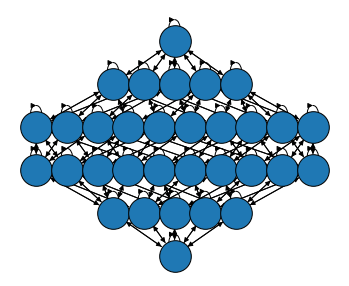

In [17]:
plot(gpm, edge_options={'arrows':'black','arrowsize':10}, figsize=(6,5))
plt.show()

As described more in-depth in the documentation for `gpmap`, we can remove self-looping edges, create a `GenotypePhenotypeGraph` object to aid with plotting, and color/label/size nodes with respect to the data columns present on `gpm.data`. 


***See `gpmap` documentation for a more in-depth discussion.***

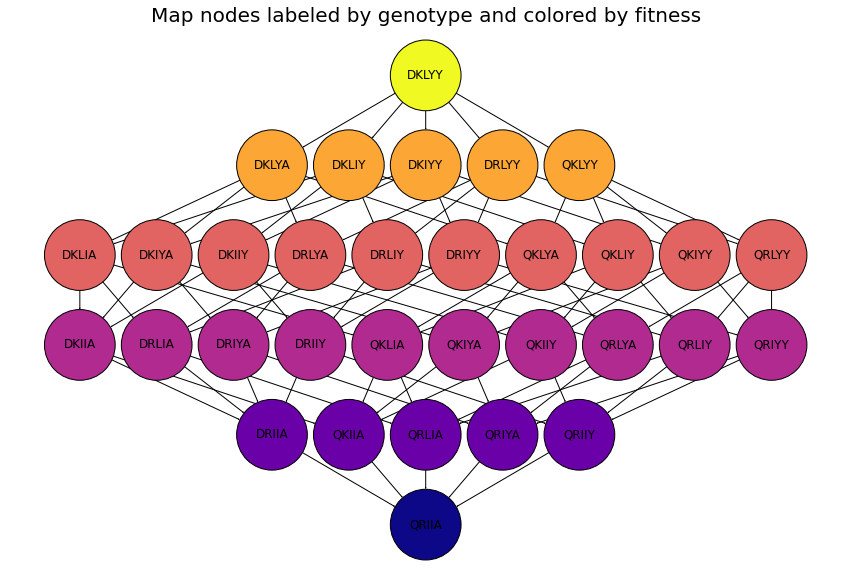

In [18]:
# Remove self-looping edges
gpm.neighbors.loc[gpm.neighbors.direction != 1,"include"] = False

# Create GenotypePhenotypeGraph object
G = GenotypePhenotypeGraph()
G.add_gpm(gpm)

# Add custom node data and labels, with chosen colormaps
G.add_node_cmap(data_column="fitness")
G.add_node_labels(data_column="genotype")

# Plot map
G, fig, ax = plot(G,figsize=(15,10),plot_node_labels=True, node_options={'node_size':5000}, edge_options={'arrows':'black','arrowsize':1})
ax.set_title("Map nodes labeled by genotype and colored by fitness", fontsize=20)
plt.show()

We can change some of these attributes to label the nodes by cluster assignment instead:

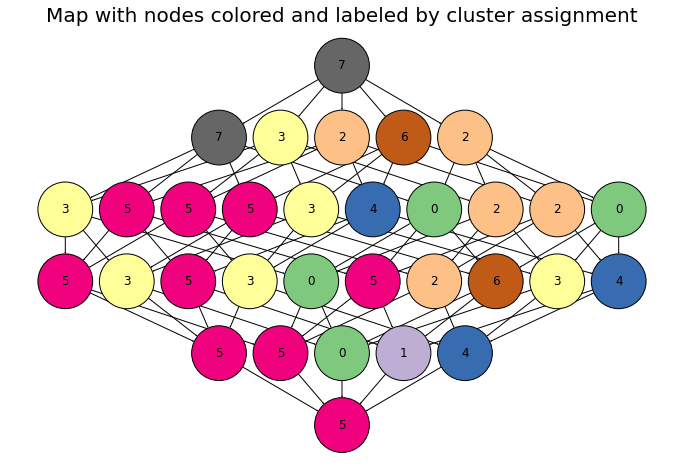

In [19]:
# Add custom node data and labels, with chosen colormaps
G.add_node_cmap(data_column="assignment", cmap='Accent')
G.add_node_labels(data_column="assignment")

# Plot map
G, fig, ax = plot(G,figsize=(12,8),plot_node_labels=True, node_options={'node_size':3000}, edge_options={'arrows':'black','arrowsize':1})
ax.set_title("Map with nodes colored and labeled by cluster assignment", fontsize=20)
plt.show()

Or size them according to their fitness value:

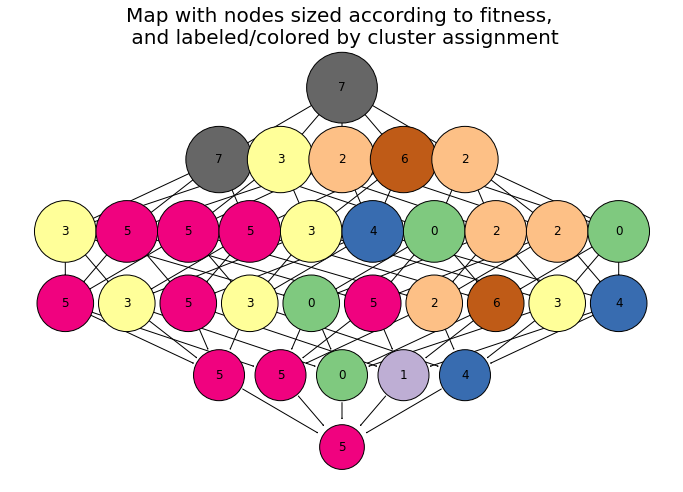

In [20]:
# Add custom node data and labels, with chosen colormaps
G.add_node_cmap(data_column="assignment", cmap='Accent')
G.add_node_labels(data_column="assignment")
G.add_node_sizemap(data_column="fitness", size_min=2000, size_max=5000)

# Plot map
G, fig, ax = plot(G,figsize=(12,8),plot_node_labels=True, edge_options={'arrows':'black','arrowsize':1})
ax.set_title("Map with nodes sized according to fitness, \n and labeled/colored by cluster assignment", fontsize=20)
plt.show()

`gpvolve` includes a function that conveniently colors and plots a map using cluster assignment:

In [21]:
from gpvolve.pyplot import plot_clusters

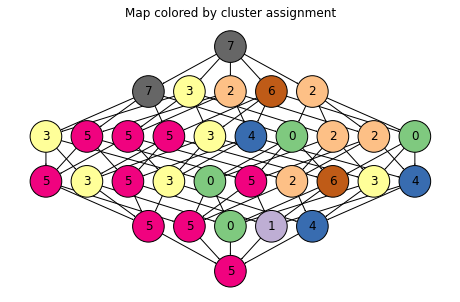

In [22]:
plot_clusters(gpm, fig_title="Map colored by cluster assignment", figsize=(8,5))
plt.show()

To best visualize the distinction between the different notes, it is recommended to use qualitative colormaps, see an example of these colormaps below:

![image](https://matplotlib.org/stable/_images/sphx_glr_colormaps_006.png)

# 6. HDBSCAN

In [23]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import sklearn.datasets as data
# %matplotlib inline
# sns.set_context('poster')
# sns.set_style('white')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}